### Library importation

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Dataset information

As explained from dataset card, images of red, yellow and green apples/tomatoes have been split into a train and test set. Image sizes usually range between 100x100 pixels and 300x300 pixels. Let's begin with image of 100x100 pixels.

Load a single image from dataset.

In [3]:
image_size = 100
image_shape = (100, 100)
batch_size = 32

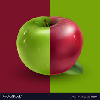

In [4]:
full_image = "/kaggle/input/apples-or-tomatoes-image-classification/train/apples/img_p1_113.jpeg"
load_img(full_image, target_size=(image_size, image_size))

### Data exploration

- check data distribution
- check duplicated images

In [5]:
train_dir = "/kaggle/input/apples-or-tomatoes-image-classification/train"
apples_images = []
tomatoes_images = []
apples_dir = 'apples'
import os
for d in os.listdir(train_dir):
    if os.path.isdir(os.path.join(train_dir, d)) and d == 'apples':
        for f in os.listdir(os.path.join(train_dir, d)):
            if os.path.isfile(os.path.join(os.path.join(train_dir, d), f)):
                apples_images.append(f)
    if os.path.isdir(os.path.join(train_dir, d)) and d == 'tomatoes':
        for f in os.listdir(os.path.join(train_dir, d)):
            if os.path.isfile(os.path.join(os.path.join(train_dir, d), f)):
                tomatoes_images.append(f)

In [6]:
len(apples_images), len(tomatoes_images)

(164, 130)

We observe that we have here an imbalanced class. We will see later how to handle imbalanced class.

In [7]:
len(set(apples_images)), len(set(tomatoes_images)) 

(164, 130)

We observe that we have only unique image in the dataset.

### Data preprocessing

In [8]:
datagen = ImageDataGenerator(
    rescale=1/255.,
    zoom_range=0.2,
    rotation_range=30,
    validation_split=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [9]:
train_dataset_dir = "/kaggle/input/apples-or-tomatoes-image-classification/train"
test_dataset_dir = "/kaggle/input/apples-or-tomatoes-image-classification/test"

In [10]:
train_ds = datagen.flow_from_directory(
    train_dataset_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    subset="training",
    seed=1
)

validation_ds = datagen.flow_from_directory(
    train_dataset_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    subset='validation',
    seed=1,
)

# For test data
test_ds = ImageDataGenerator(rescale=1/255.).flow_from_directory(
    test_dataset_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False  # Set shuffle to False for test data
)

Found 236 images belonging to 2 classes.
Found 58 images belonging to 2 classes.
Found 97 images belonging to 2 classes.


### Building sequential neural network

First let's start with a sequential neural network. We will use callbacks when training our model which hepl us to improve the training process.
Callbacks have some functionnalies such as early stopping, learning rate tuning, best model dumping, ...
Also we will Strategy that let's us performing distributed computational power in keras.  

In [11]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 5 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=10) #if val loss decrease for 5 epochs in a row, stop training

# Creating learning rate reduce callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, #multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=3,
                                                 verbose=1,
                                                 min_lr=1e-7)

In [12]:
strategy = tf.distribute.MirroredStrategy()
print(f"Nombre de périphériques : {strategy.num_replicas_in_sync}")


Nombre de périphériques : 2


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

In [14]:
with strategy.scope():
    model = Sequential([
        Input(shape=(100, 100, 3)),  # Ajoute une couche d'entrée explicite
        Conv2D(32, kernel_size = (3,3), activation='relu', padding = 'same'),
        MaxPooling2D((2, 2)),
        Conv2D(64, kernel_size = (3,3), activation='relu', padding = 'same'),
        MaxPooling2D((2, 2)),
        Dropout(.2),
        Flatten(),
        Dense(32, activation='relu'),
        Dropout(.2),
        Dense(32, activation='relu'),
        Dense(2, activation = 'softmax')
    ])

    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

Handle unbalacend class when training model

In [15]:
from sklearn.utils import class_weight
import numpy as np

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_ds.classes),
    y=train_ds.classes
)
class_weights_dict = dict(enumerate(class_weights))

print("Class Weights: ", class_weights_dict)


Class Weights:  {0: 0.8939393939393939, 1: 1.1346153846153846}


In [16]:
train_ds

In [17]:
history = model.fit(train_ds, epochs=50, validation_data = validation_ds, callbacks = [early_stopping, reduce_lr])

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 251ms/step - accuracy: 0.5163 - loss: 0.8006 - val_accuracy: 0.5862 - val_loss: 0.6536 - learning_rate: 0.0010
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.6751 - loss: 0.6289 - val_accuracy: 0.5862 - val_loss: 0.6735 - learning_rate: 0.0010
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.6701 - loss: 0.6049 - val_accuracy: 0.5517 - val_loss: 0.7370 - learning_rate: 0.0010
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.6741 - loss: 0.6028 - val_accuracy: 0.7241 - val_loss: 0.6335 - learning_rate: 0.0010
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.6739 - loss: 0.6151 - val_accuracy: 0.6207 - val_loss: 0.6202 - learning_rate: 0.0010
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.6604 - loss: 0.6172 - val_accuracy: 0.5517 - val_loss: 0.6779 - learning_rate: 0.0010
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.6903 - loss: 0.5622 - val_accuracy: 

In [18]:
model.evaluate(validation_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.6290 - loss: 0.6521


[0.6714949607849121, 0.6551724076271057]

In [19]:
model.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6592 - loss: nan


[0.5826582908630371, 0.6938775777816772]

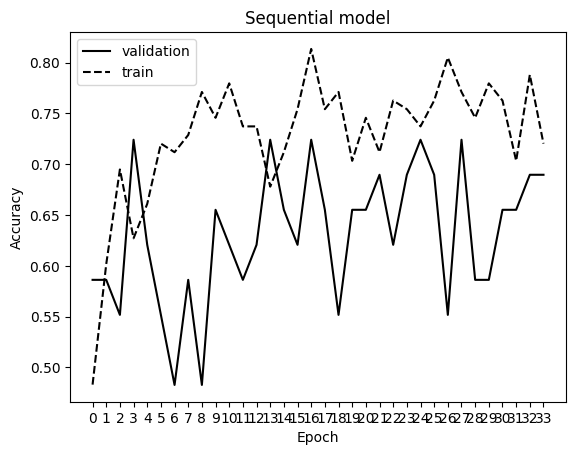

In [20]:
epochs = np.arange(len(history.history['accuracy']))
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, val_acc, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train_acc, color='black', linestyle='dashed', label='train')

plt.title('Sequential model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()

plt.show()



### Using transfer learning

#### EfficientNetB3

In [21]:
# Create pre-trained model
base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3), pooling='max')
for layer in base_model.layers:
    layer.trainable = False

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
from tensorflow.keras.layers import BatchNormalization

In [23]:

# model_v1 = Sequential([
#     base_model,
#     Dense(32, activation='relu'),
#     Dropout(.2),
#     Dense(32, activation='relu'),
#     Dense(2, activation = 'softmax')
# ])

model_v1 = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='softmax')
])

model_v1.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [24]:
history = model_v1.fit(train_ds, epochs=50, validation_data = test_ds, callbacks = [early_stopping, reduce_lr])

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 0.4894 - loss: 1.2977 - val_accuracy: 0.5567 - val_loss: 15.5054 - learning_rate: 0.0010
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5287 - loss: 1.2172 - val_accuracy: 0.5567 - val_loss: 9.6835 - learning_rate: 0.0010
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5106 - loss: 1.1740 - val_accuracy: 0.5567 - val_loss: 2.6587 - learning_rate: 0.0010
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5430 - loss: 0.9773 - val_accuracy: 0.5567 - val_loss: 6.0343 - learning_rate: 0.0010
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5990 - loss: 0.9708 - val_accuracy: 0.5567 - val_loss: 1.8658 - learning_rate: 0.0010
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.4764 - loss: 0.9883 - val_accuracy: 0.6701 - val_loss: 0.6695 - learning_rate: 0.0010
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5161 - loss: 0.9480 - val_accuracy: 0.5567 

In [25]:
model_v1.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7039 - loss: 0.6277


[0.8479114770889282, 0.5567010045051575]

#### VGG16

In [26]:
base_model = tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3), pooling='max')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [27]:
for layer in base_model.layers:
    layer.trainable = False
    
model_v2 = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

model_v2.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

Add checkpoint to save best model.

In [28]:
checkpoint = keras.callbacks.ModelCheckpoint(
        "vgg16_{epoch:02d}_{val_accuracy:.3f}.keras",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )

In [29]:
history = model_v2.fit(train_ds, epochs=50, validation_data = test_ds, callbacks = [early_stopping, reduce_lr, checkpoint])

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 938ms/step - accuracy: 0.5750 - loss: 0.8501 - val_accuracy: 0.6598 - val_loss: 0.6216 - learning_rate: 0.0010
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.7348 - loss: 0.6798 - val_accuracy: 0.7423 - val_loss: 0.5514 - learning_rate: 0.0010
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.7949 - loss: 0.4780 - val_accuracy: 0.7526 - val_loss: 0.5545 - learning_rate: 0.0010
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8580 - loss: 0.3674 - val_accuracy: 0.6907 - val_loss: 0.5704 - learning_rate: 0.0010
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8419 - loss: 0.3565 - val_accuracy: 0.7010 - val_loss: 0.5507 - learning_rate: 0.0010
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.8037 - loss: 0.4033 - val_accuracy: 0.7010 - val_loss: 0.5357 - learning_rate: 0.0010
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8601 - loss: 0.3561 - val_accuracy: 0.711

#### Model evaluation

In [30]:
model_v2.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6846 - loss: 0.5619


[0.5375194549560547, 0.7010309100151062]

In [31]:
train_score = model_v2.evaluate(train_ds)
valid_score = model_v2.evaluate(validation_ds)
test_score = model_v2.evaluate(test_ds)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.8904 - loss: 0.3585
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.7349 - loss: 0.5138
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6846 - loss: 0.5619
Train Loss:  0.3427690863609314
Train Accuracy:  0.8983050584793091
--------------------
Validation Loss:  0.49635908007621765
Validation Accuracy:  0.7586206793785095
--------------------
Test Loss:  0.5375194549560547
Test Accuracy:  0.7010309100151062


In [32]:
preds = model_v2.predict(test_ds)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step
[1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 0 1 0 0 1 0
 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1
 1 0 0 1 0 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 0]


In [33]:
target_names = ['apples','tomatoes', ]

In [34]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Classification report
print(classification_report(test_ds.classes, y_pred, target_names= target_names))

              precision    recall  f1-score   support

      apples       0.77      0.67      0.71        54
    tomatoes       0.64      0.74      0.69        43

    accuracy                           0.70        97
   macro avg       0.70      0.71      0.70        97
weighted avg       0.71      0.70      0.70        97



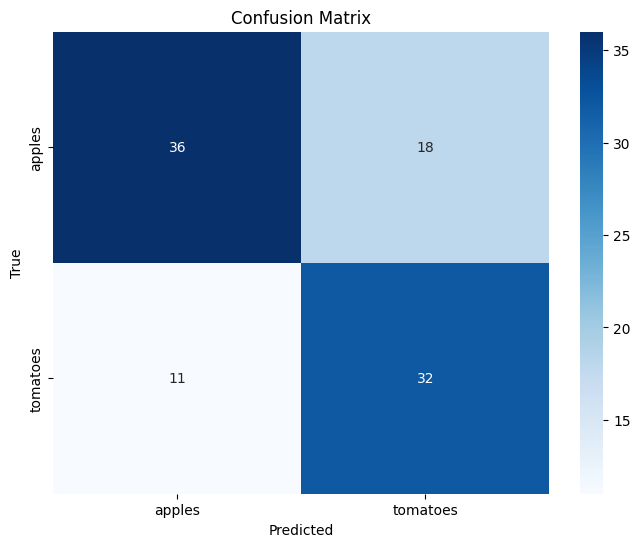

In [35]:
# Confusion matrix
cm = confusion_matrix(test_ds.classes, y_pred)

# Plot using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### Using best model for prediction

In [36]:
classes = [
    'apples',
    'tomatoes',
]

In [37]:
from glob import glob

best_model_name = max(glob(os.path.join('/kaggle/working', "vgg16_*.keras")))
best_model = keras.models.load_model(best_model_name)

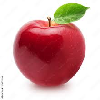

In [38]:
image_to_test = '/kaggle/input/apples-or-tomatoes-image-classification/test/apples/img_p1_50.jpeg'
img_to_test = load_img(image_to_test, target_size=(100, 100))
img_to_test

In [39]:
x = np.array(img_to_test)
X = np.array([x])

prediction = best_model.predict(X)
dict(zip(classes, prediction[0]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step


{'apples': 1.0, 'tomatoes': 3.495545e-12}

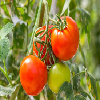

In [40]:
image_to_test = '/kaggle/input/apples-or-tomatoes-image-classification/test/tomatoes/img_p1_53.jpeg'
img_to_test = load_img(image_to_test, target_size=(100, 100))
img_to_test

In [41]:
x = np.array(img_to_test)
X = np.array([x])
prediction = best_model.predict(X)
dict(zip(classes, prediction[0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


{'apples': 0.9999871, 'tomatoes': 1.2921869e-05}